In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from os import path
from sklearn.decomposition import PCA
import sklearn
from glob import glob
import codecs
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
class Text(): 
    def __init__(self, filename, topWords, chunkSize=5000, maxPieces=1, 
                 equalPieces=False, maxLen=False): 
        with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
            self.raw = fdata.read().lower()
        self.name = path.splitext(path.basename(filename))[0]
        
        # Use the filename to generate metadata like author name and date of publication. 
        # This assumes files named like austen-1811-mansfield.txt
        nameParts = self.name.split('-')
        self.author = nameParts[0]
        self.date = nameParts[1]
        
        self.tokens = nltk.tokenize.word_tokenize(self.raw) 
        
        if equalPieces: 
            # Break up the text into N equal-sized chunks, where n=maxPieces. 
            # Truncate the text at maxLen. 
            self.pieces = self.getEqualPieces(self.tokens, maxPieces, maxLen)
        else: 
            self.pieces = self.getPieces(self.tokens, chunkSize, maxPieces)

        # self.tokens = [word for word in self.tokens if word.isalpha()] # strip punctuation
        self.numPieces = len(self.pieces)
        self.chunkSize = len(self.pieces[0])
        
        if topWords:
            self.freqDists = []
            for piece in self.pieces: 
                mc = nltk.FreqDist(piece).most_common(topWords)
                d = {item[0]: item[1] for item in mc}
                self.freqDists.append(d)
        else: 
            self.freqDists = [nltk.FreqDist(piece) for piece in self.pieces]
        dfIndex = [self.name + '-' + str(i) for i in range(self.numPieces)]
        self.df = pd.DataFrame(self.freqDists, index=dfIndex).fillna(0)
        
        # I can't figure out how to get sklearn to CountVectorize on already-tokenized text, so 
        # putting this on hold for now. 
        #vectorizer = CountVectorizer(input='filename')
        #countMatrix = vectorizer.fit_transform(self.pieces).todense()
        #wordLabels = vectorizer.get_feature_names()
        #self.df = pd.DataFrame(countMatrix, columns=matrixLabels, index=textList)
        
    def __repr__(self): 
        return "Text %s: %s pieces of %s words each" % (self.name, self.numPieces, self.chunkSize)
    
    def __len__(self): 
        return len(self.tokens)
    
    def getPieces(self, text, length, num): 
        """ Chunk a text into `num` chunks of size `length`."""
        out = [] 
        for x in range(num): 
            out.append(text[length*x:length*(x+1)])
        return out
    
    def getEqualPieces(self, text, num, maxLen): 
        """ Divide a text into `num` equal pieces, also truncating at maxLen. """
        truncated = text[:maxLen]
        length = len(truncated)
        pieceSize = round(length / num)
        return self.getPieces(text, pieceSize, num)

In [25]:
class TextComparison(): 
    def __init__(self, filenames, numPieces=2, topWords=100):
        self.texts = [Text(filename, topWords=topWords) for filename in filenames]

        # Determine text with lowest word count. 
        # Truncate all other texts to this value. 
        cutoff = min(self.wordCounts.values())
        
        # TODO: make this so it doesn't have to instantiate a whole new text object each time. 
        # Maybe just get the word count some other way. 
        self.texts = [Text(filename, topWords=topWords, maxPieces=numPieces, equalPieces=True, maxLen=cutoff) for filename in filenames]
        
        self.dfs = [text.df for text in self.texts]
        self.df = pd.concat(self.dfs).fillna(0)
        self.labels = list(self.df.index)
        self.dates = [int(text.date) for text in self.texts]
        
    @property
    def pieceDates(self):
        dateList = []
        for text in self.texts: 
            theseDates = [int(text.date)] * text.numPieces
            dateList += theseDates
        return dateList

    @property
    def colors(self, by='date'): 
        if by == 'text': 
            colors = ['red', 'blue', 'green', 'yellow', 'purple'] * 10
            fullColorVec = []
            for i, text in enumerate(self.texts): 
                colorVec = [colors[i]] * text.numPieces
                fullColorVec += colorVec
        if by == 'date':    
            fullColorVec = plt.cm.rainbow(self.rescale(self.pieceDates, 0, 1))
        return fullColorVec
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    @property
    def wordCounts(self): 
        wordCountsDict = {text.name: len(text) for text in self.texts} 
        #pd.Series(wordCountsDict).plot(kind='bar')
        return wordCountsDict
    
    def doPCA(self, labels=False, saveTo=False): 
        pca = PCA(n_components=2)
        pcaTable = pca.fit_transform(self.df)
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        ax = plt.scatter(df[0], df[1], s=self.size, color=self.colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False).head()

# Thomas Mann

In [17]:
textList = glob('data/mann*')
t = TextComparison(textList)
textList

['data/mann-1903-tristan.txt',
 'data/mann-1903-tonio.txt',
 'data/mann-1897-kleine-herr.txt',
 'data/mann-1909-königliche.txt',
 'data/mann-1943-doktor.txt',
 'data/mann-1912-tod.txt',
 'data/mann-1902-gladius.txt',
 'data/mann-1901-buddenbrooks.txt']

,0,1,distance
mann-1897-kleine-herr-1,121.145048,24.489235,123.595491
mann-1909-königliche-1,98.471175,-64.089905,117.490800
mann-1943-doktor-0,-85.452413,-78.457911,116.007581
mann-1903-tonio-1,-34.882555,101.995585,107.795602
mann-1943-doktor-1,-91.660348,-37.887515,99.182071


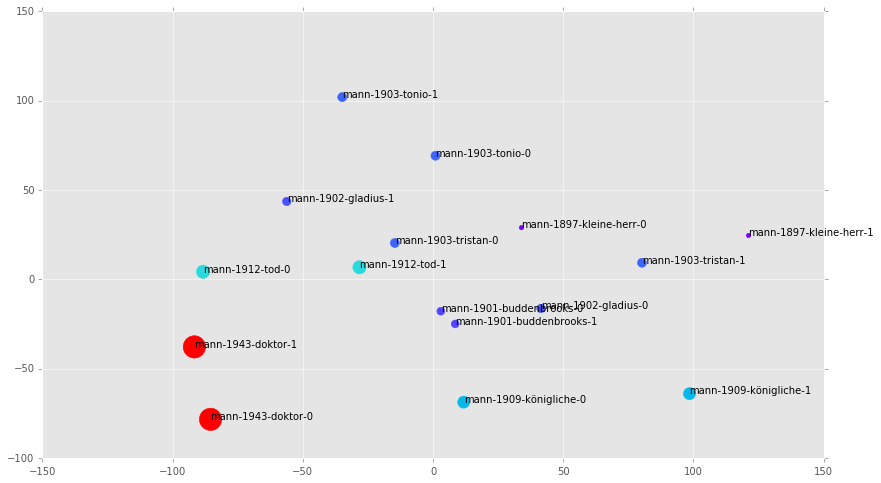

In [18]:
df = t.doPCA(labels=True)
df

# Marcel Proust

In [19]:
textList = glob('data/proust*')
t = TextComparison(textList)
textList

['data/proust-1920-guermantes.txt',
 'data/proust-1919-lombre.txt',
 'data/proust-1927-retrouve.txt',
 'data/proust-1923-prisonniere.txt',
 'data/proust-1921-sodome.txt',
 'data/proust-1925-albertine.txt',
 'data/proust-1913-swann.txt']

,0,1,distance
proust-1925-albertine-0,804.949343,355.467813,879.943641
proust-1923-prisonniere-0,523.755600,-305.642391,606.413390
proust-1923-prisonniere-1,93.998473,-532.655683,540.886115
proust-1913-swann-0,-206.383330,427.418351,474.637257
proust-1913-swann-1,-445.063473,163.912562,474.287701


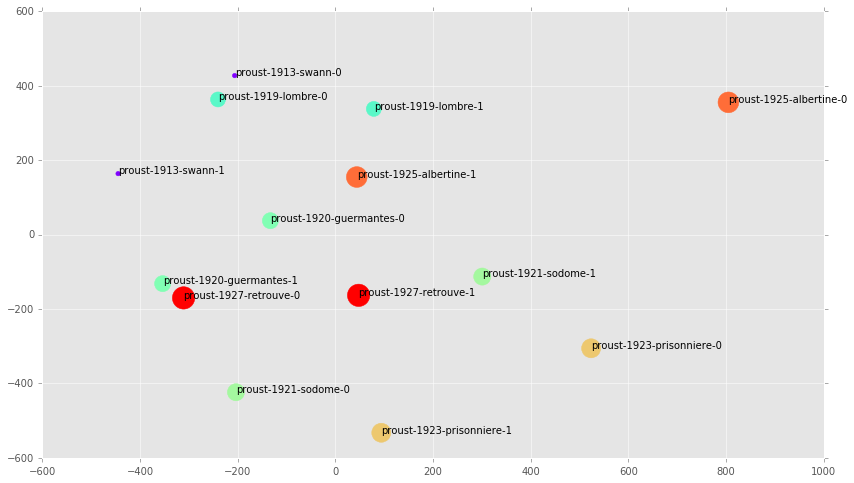

In [20]:
df = t.doPCA(labels=True)
df

# Arnold Bennett

In [8]:
textList = glob('data/bennett*')
t = TextComparison(textList)
textList

['data/bennett-1923-riceyman.txt',
 'data/bennett-1916-these-twain.txt',
 'data/bennett-1928-strange-vanguard.txt',
 'data/bennett-1929-accident.txt',
 'data/bennett-1910-clayhanger.txt',
 'data/bennett-1911-card.txt',
 'data/bennett-1908-old-wives.txt',
 'data/bennett-1930-imperial.txt',
 'data/bennett-1902-anna.txt',
 'data/bennett-1902-grand-babylon.txt']

,0,1,distance
bennett-1910-clayhanger-0,1844.319240,-593.689549,1937.519223
bennett-1910-clayhanger-1,1638.488534,-872.612715,1856.366782
bennett-1902-grand-babylon-0,247.166909,1243.766872,1268.088133
bennett-1902-grand-babylon-1,301.535465,1218.574402,1255.327531
bennett-1902-anna-1,235.535670,1187.792113,1210.919962


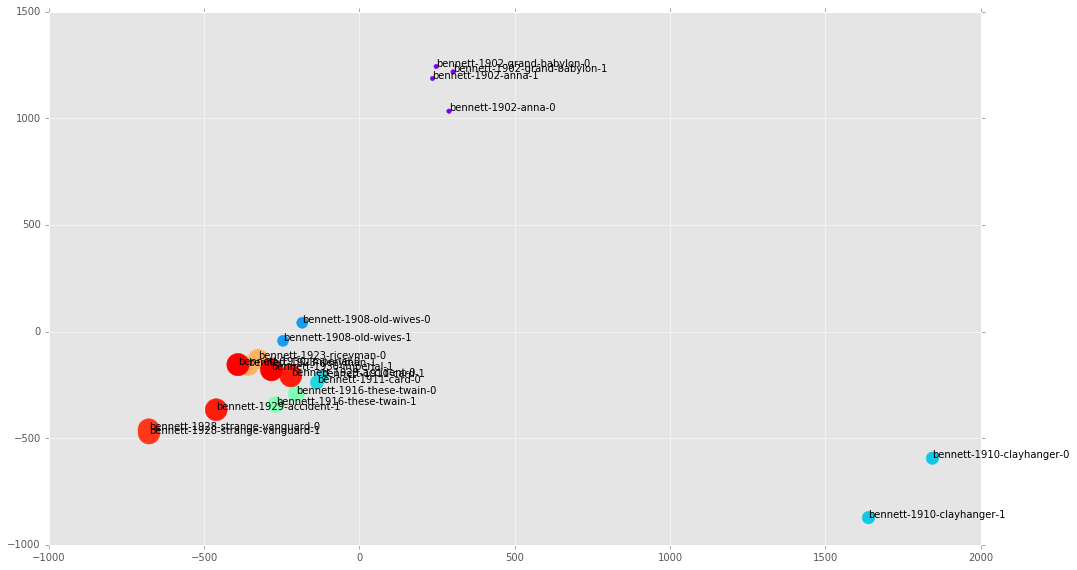

In [9]:
df = t.doPCA(labels=True, saveTo='bennett-2')
df

# Mary Augusta Ward (Mrs. Humphry Ward)

In [14]:
textList = glob('data/ward*')
t = TextComparison(textList)
textList

['data/ward-1913-mating.txt',
 'data/ward-1917-missing.txt',
 'data/ward-1900-eleanor.txt',
 'data/ward-1888-robert.txt',
 'data/ward-1915-success.txt',
 'data/ward-1908-diana.txt',
 'data/ward-1903-lady-rose.txt',
 'data/ward-1916-connie.txt',
 'data/ward-1892-grieve.txt',
 'data/ward-1898-helbeck.txt',
 'data/ward-1896-tressady.txt',
 'data/ward-1920-harvest.txt',
 'data/ward-1894-marcella.txt',
 'data/ward-1905-marriage.txt']

,0,1,distance
ward-1888-robert-1,522.728412,-276.038009,591.136173
ward-1915-success-1,-397.391417,355.268754,533.043925
ward-1903-lady-rose-1,-518.373332,-117.440171,531.510211
ward-1900-eleanor-0,347.762492,389.088203,521.850918
ward-1892-grieve-0,497.575120,-129.756783,514.215736


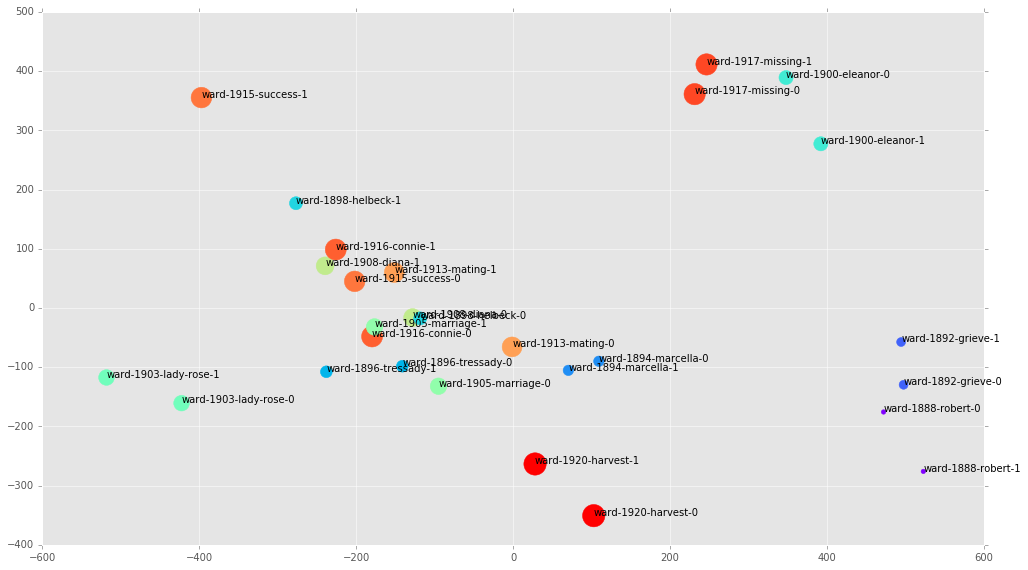

In [15]:
df = t.doPCA(labels=True, saveTo='ward-nomilly')
df

# Anthony Trollope

In [21]:
textList = glob('data/trollope*')
t = TextComparison(textList)
textList

['data/trollope-1875-way-we-live.txt',
 'data/trollope-1855-warden.txt',
 'data/trollope-1877-american-senator.txt',
 'data/trollope-1884-old-man.txt',
 'data/trollope-1869-phineas.txt',
 'data/trollope-1858-doctor-thorne.txt',
 'data/trollope-1857-barchester.txt',
 'data/trollope-1883-landleaguers.txt',
 'data/trollope-1864-house-at.txt',
 'data/trollope-1865-can-you-forgive.txt',
 'data/trollope-1861-framley.txt',
 'data/trollope-1867-last-chronicle.txt']

,0,1,distance
trollope-1855-warden-0,1268.428810,-147.739803,1277.003796
trollope-1857-barchester-0,938.994767,537.900854,1082.149944
trollope-1855-warden-1,964.736241,-133.931821,973.988576
trollope-1877-american-senator-1,-877.470264,298.105715,926.726001
trollope-1884-old-man-1,-879.107697,-196.099582,900.713822


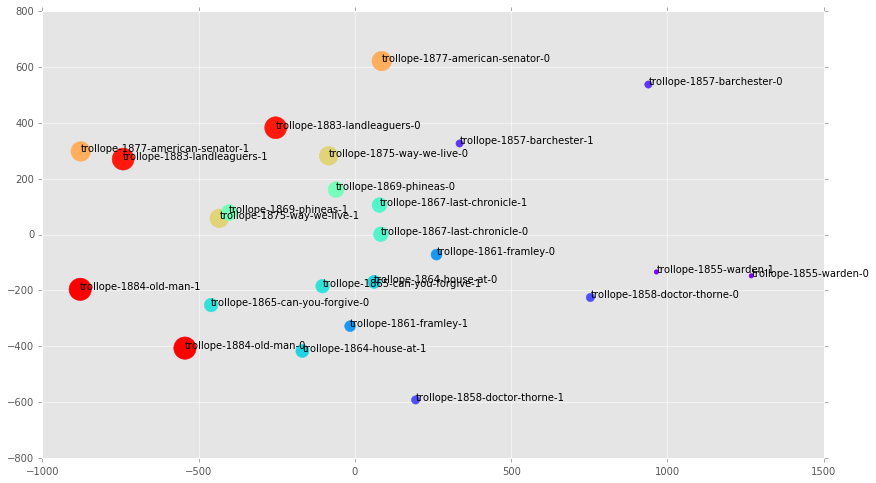

In [22]:
df = t.doPCA(labels=True)
df